In [96]:
import json
import numpy
import requests
from bs4 import BeautifulSoup
from espncricinfo.exceptions import MatchNotFoundError, NoScorecardError
import pandas as pd

class Match(object):
    def __init__(self, match_id):
        self.match_id = match_id
        self.match_url = f"https://site.api.espn.com/apis/site/v2/sports/cricket/8048/summary?event={match_id}"
        self.json_url = f"https://www.espncricinfo.com/matches/engine/match/{match_id}.json"
        self.json = self.get_json()
        self.json_api = self.get_json_api()
        self.description = self.get_description()
        self.full_scorecard_url = self.get_full_scorecard_url()
        self.toss = self.get_toss()
        self.team1 = self.get_team1()
        self.team2 = self.get_team2()
        self.team1_batting_df = self.get_team1_batting_df()
        self.team2_batting_df = self.get_team2_batting_df()
        self.team1_bowling_df = self.get_team1_bowling_df()
        self.team2_bowling_df = self.get_team2_bowling_df()
        self.dream11_points = self.get_dream11_points()
        
    def get_json(self):
        r = requests.get(self.json_url)
        if r.status_code == 404:
            raise MatchNotFoundError
        elif 'Scorecard not yet available' in r.text:
            raise NoScorecardError
        else:
            return r.json()
    
    def get_json_api(self):
        r = requests.get(self.match_url)
        if r.status_code == 404:
            raise MatchNotFoundError
        elif 'Scorecard not yet available' in r.text:
            raise NoScorecardError
        else:
            return r.json()
        
    def get_full_scorecard_url(self):
        url  = self.description
        matchName = url.split(",")[1].split(":")[1].strip().split(" ")[:-2]
        firstHalf = '-'.join(matchName).lower().replace("-v-", "-vs-")
        matchNo = url.split(",")[1].split(":")[0].replace(" ","-").lower()
        finalurl = firstHalf + matchNo + "-" + str(self.match_id)
        return f"https://www.espncricinfo.com/series/indian-premier-league-2024-1410320/{finalurl}/full-scorecard"
    
    def get_description(self):
        return self.json['description']
    
    def get_toss(self):
        return self.json_api['gameInfo']['venue']['fullName']
    
    def get_team1(self):
        team = []
        for i in self.json_api['rosters'][0]['roster']:
             team.append(i['athlete']['name'])
        return team
    
    def get_team2(self):
        team = []
        for i in self.json_api['rosters'][1]['roster']:
             team.append(i['athlete']['name'])
        return team
    
    def get_team1_batting_df(self):
        r = requests.get(self.full_scorecard_url)
        soup = BeautifulSoup(r.content, 'html.parser')
        df = pd.DataFrame(columns= ['Name', "Wicket", "Runs", "Balls", "Fours", "Sixes"])
        tables = soup.find_all('table')
        brows = tables[0].findAll('tr')[1:-4]
        for brow in brows:
            x  = brow.findAll('td')
            if len(x) == 1:
                continue
            name = x[0].text
            name2 = name.replace('(c)','')
            name3 = name2.replace('†', '')
            name3 = name3.strip()
            df.loc[len(df)] = [name3, x[1].text, x[2].text, x[3].text, x[5].text, x[6].text]
        df[["Runs", "Balls", "Fours", "Sixes"]] = df[["Runs", "Balls", "Fours", "Sixes"]].astype(int)
        df["Strike Rate"] = (df["Runs"] / df["Balls"] * 100).round(2)
        return df

    def get_team2_batting_df(self):
        r = requests.get(self.full_scorecard_url)
        soup = BeautifulSoup(r.content, 'html.parser')
        df = pd.DataFrame(columns= ['Name', "Wicket", "Runs", "Balls", "Fours", "Sixes"])
        tables = soup.find_all('table')
        brows = tables[2].findAll('tr')[1:-4]
        for brow in brows:
            x  = brow.findAll('td')
            if len(x) == 1:
                continue
            name = x[0].text
            name2 = name.replace('(c)','')
            name3 = name2.replace('†', '')
            name3 = name3.strip()
            df.loc[len(df)] = [name3, x[1].text, x[2].text, x[3].text, x[5].text, x[6].text]
        df[["Runs", "Balls", "Fours", "Sixes"]] = df[["Runs", "Balls", "Fours", "Sixes"]].astype(int)
        df["Strike Rate"] = (df["Runs"] / df["Balls"] * 100).round(2)
        return df
    
    def get_team1_bowling_df(self):
        table = pd.read_html(self.full_scorecard_url)
        df = table[1]
        df = df[~df['BOWLING'].str[0].str.isdigit()]
        df.rename(columns = {'O':'Overs', 'M' : 'Maidens', 'R' : 'Runs', 'W' : 'Wickets', 'ECON' : 'Economy'} , inplace= True)
        df[["Overs", "Economy",]] = df[["Overs","Economy"]].astype(float)
        df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]] = df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]].astype("int")
        return df
    
    def get_team2_bowling_df(self):
        table = pd.read_html(self.full_scorecard_url)
        df = table[3]
        df = df[~df['BOWLING'].str[0].str.isdigit()]
        df.rename(columns = {'O':'Overs', 'M' : 'Maidens', 'R' : 'Runs', 'W' : 'Wickets', 'ECON' : 'Economy'} , inplace= True)
        df[["Overs", "Economy",]] = df[["Overs","Economy"]].astype(float)
        df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]] = df[["Maidens", "Runs", "Wickets", "0s", "4s", "6s", "WD", "NB"]].astype("int")
        return df
    
    def get_dream11_points(self):
        return None
    



In [97]:
matchNumber = 1426295

m = Match(matchNumber)
m.team1

/tmp/ipykernel_50248/1171486245.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'O':'Overs', 'M' : 'Maidens', 'R' : 'Runs', 'W' : 'Wickets', 'ECON' : 'Economy'} , inplace= True)
/tmp/ipykernel_50248/1171486245.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["Overs", "Economy",]] = df[["Overs","Economy"]].astype(float)
/tmp/ipykernel_50248/1171486245.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

['Abhishek Sharma',
 'Travis Head',
 'Nitish Kumar Reddy',
 'Heinrich Klaasen',
 'Abdul Samad',
 'Shahbaz Ahmed',
 'Sanvir Singh',
 'Pat Cummins',
 'Bhuvneshwar Kumar',
 'Jaydev Unadkat',
 'Vijayakanth Viyaskanth',
 'T Natarajan']

In [98]:
m.team1

['Abhishek Sharma',
 'Travis Head',
 'Nitish Kumar Reddy',
 'Heinrich Klaasen',
 'Abdul Samad',
 'Shahbaz Ahmed',
 'Sanvir Singh',
 'Pat Cummins',
 'Bhuvneshwar Kumar',
 'Jaydev Unadkat',
 'Vijayakanth Viyaskanth',
 'T Natarajan']

In [99]:
m.team1_batting_df

# m.team2_bowling_df

,Name,Wicket,Runs,Balls,Fours,Sixes,Strike Rate
0,KL Rahul,c Natarajan b Cummins,29,33,1,1,87.88
1,Quinton de Kock,c Nitish Kumar Reddy b Kumar,2,5,0,0,40.00
2,Marcus Stoinis,c Sanvir Singh b Kumar,3,5,0,0,60.00
3,Krunal Pandya,run out (Cummins),24,21,0,2,114.29
4,Nicholas Pooran,not out,48,26,6,1,184.62
5,Ayush Badoni,not out,55,30,9,0,183.33


In [104]:
x = m.team2_batting_df

x['Fantasy Points'] = x['Runs'] + x['Fours'] + x['Sixes']*2
x['Fantasy Points'] = x['Runs'] + x['Fours'] + x['Sixes']*2
x['Fantasy Points'] = numpy.where(x['Runs'] > 50, x['Fantasy Points'] + 8, x['Fantasy Points'])
x['Fantasy Points'] = numpy.where(x['Runs'] > 100, x['Fantasy Points'] + 8, x['Fantasy Points'])
x['Fantasy Points'] = numpy.where((x['Runs'] == 0) & (x['Wicket'] != 'not out '), x['Fantasy Points'] - 2 , x['Fantasy Points'])
x['Fantasy Points'] = numpy.where((x['Strike Rate'] <=70 ) & (x['Balls'] >= 10), x['Fantasy Points'] - 2 , x['Fantasy Points'])
x['Fantasy Points'] = numpy.where((x['Strike Rate'] <60) & (x['Balls'] >= 10), x['Fantasy Points'] - 2 , x['Fantasy Points'])
x['Fantasy Points'] = numpy.where((x['Strike Rate'] <50 ) & (x['Balls'] >= 10), x['Fantasy Points'] - 2 , x['Fantasy Points'])

y = m.team1_bowling_df

y['Fantasy Points'] = y['Wickets']*25 + y['Maidens']*8 
y['Fantasy Points'] = numpy.where(y['Wickets'] >= 4, y['Fantasy Points'] + 8, y['Fantasy Points'])
y['Fantasy Points'] = numpy.where(y['Wickets'] >= 5, y['Fantasy Points'] + 8, y['Fantasy Points'])
y['Fantasy Points'] = numpy.where((y['Economy'] <= 6) & (y['Overs'] >=2) , y['Fantasy Points'] +2, y['Fantasy Points'])
y['Fantasy Points'] = numpy.where((y['Economy'] <= 5) & (y['Overs'] >=2), y['Fantasy Points'] +2, y['Fantasy Points'])

x

,Name,Wicket,Runs,Balls,Fours,Sixes,Strike Rate,Fantasy Points
0,Abhishek Sharma,not out,75,28,8,6,267.86,103
1,Travis Head,not out,89,30,8,8,296.67,121


In [101]:

# Same for Strike Rate
# x["Fantasy Points"][x["Runs"] > 50] = x["Fantasy Points"] + 8
# x["Fantasy Points"][x["Runs"] > 100] = x["Fantasy Points"] + 16
# x["Fantasy Points"][x["Runs"] == 0] = x["Fantasy Points"] - 2

# y["Fantasy Points"] = y["Runs"] + y["Fours"] + y["Sixes"]*2
# y["Fantasy Points"][y["Runs"] > 50] = y["Fantasy Points"] + 8
# y["Fantasy Points"][y["Runs"] > 100] = y["Fantasy Points"] + 16
# y["Fantasy Points"][y["Runs"] == 0] = y["Fantasy Points"] - 2

x


,Name,Wicket,Runs,Balls,Fours,Sixes,Strike Rate,Fantasy Points
0,KL Rahul,c Natarajan b Cummins,29,33,1,1,87.88,32
1,Quinton de Kock,c Nitish Kumar Reddy b Kumar,2,5,0,0,40.00,2
2,Marcus Stoinis,c Sanvir Singh b Kumar,3,5,0,0,60.00,3
3,Krunal Pandya,run out (Cummins),24,21,0,2,114.29,28
4,Nicholas Pooran,not out,48,26,6,1,184.62,56
5,Ayush Badoni,not out,55,30,9,0,183.33,72


<Axes: xlabel='Name'>

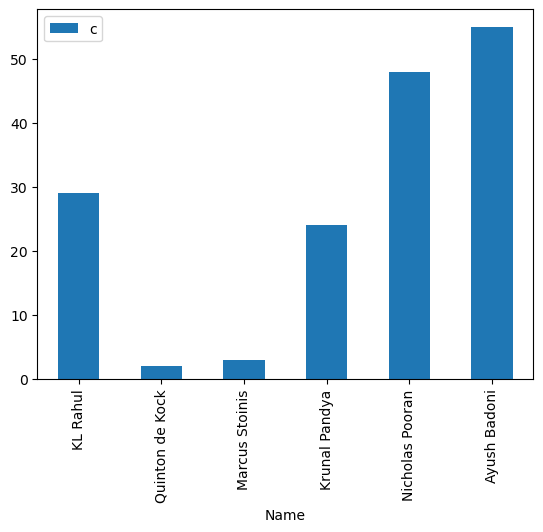

In [102]:
# x["Fantasy Points"].plot()
x.plot.bar(x='Name', y='Runs', label='c')